Loaded dataset: diabetes_binary_5050split_health_indicators_BRFSS2015.csv
Epoch 0 | D Loss: 0.6638, Acc: 0.6582 | G Loss: 0.6565
Epoch 100 | D Loss: 0.6953, Acc: 0.5029 | G Loss: 0.6371
Epoch 200 | D Loss: 0.7023, Acc: 0.4845 | G Loss: 0.6262
Epoch 300 | D Loss: 0.7073, Acc: 0.4740 | G Loss: 0.6179
Epoch 400 | D Loss: 0.7112, Acc: 0.4677 | G Loss: 0.6118
Epoch 500 | D Loss: 0.7144, Acc: 0.4628 | G Loss: 0.6070
Epoch 600 | D Loss: 0.7170, Acc: 0.4588 | G Loss: 0.6032
Epoch 700 | D Loss: 0.7190, Acc: 0.4562 | G Loss: 0.5997
Epoch 800 | D Loss: 0.7208, Acc: 0.4540 | G Loss: 0.5969
Epoch 900 | D Loss: 0.7224, Acc: 0.4521 | G Loss: 0.5944


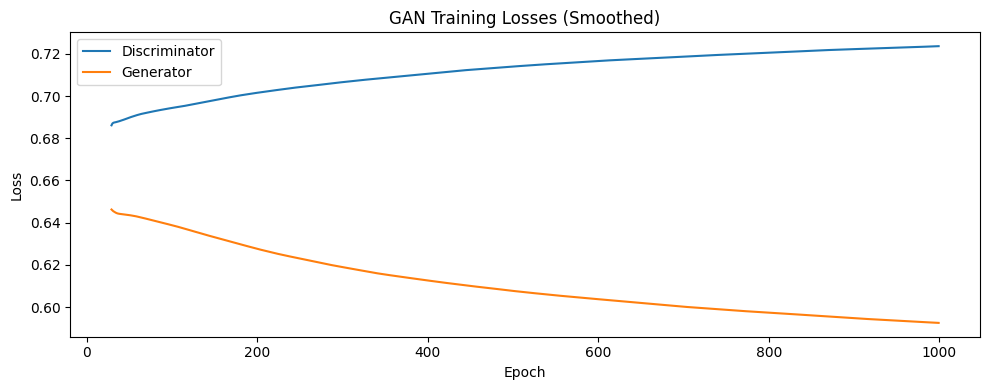

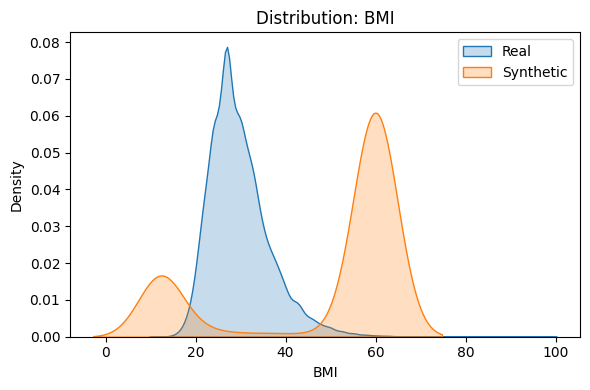

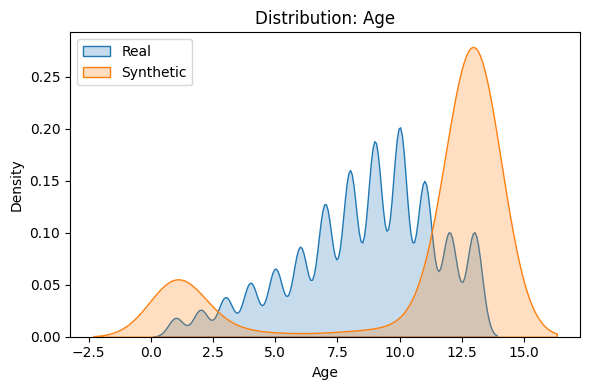

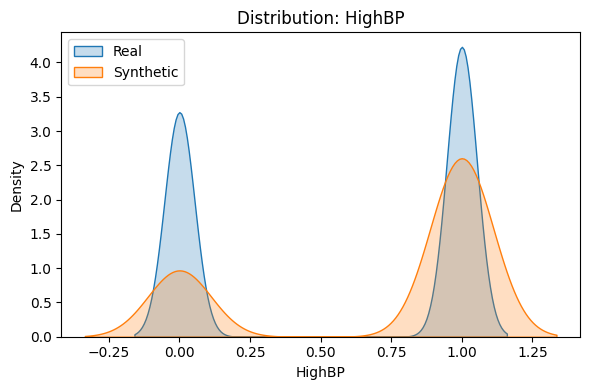


Real Data Summary:
                 BMI           Age        HighBP
count  70692.000000  70692.000000  70692.000000
mean      29.856985      8.584055      0.563458
std        7.113954      2.852153      0.495960
min       12.000000      1.000000      0.000000
25%       25.000000      7.000000      0.000000
50%       29.000000      9.000000      1.000000
75%       33.000000     11.000000      1.000000
max       98.000000     13.000000      1.000000

Synthetic Data Summary:
                BMI          Age       HighBP
count  1000.000000  1000.000000  1000.000000
mean     49.014969    10.788000     0.729000
std      19.556211     4.407321     0.444699
min      12.000001     1.000000     0.000000
25%      53.203530    12.000000     0.000000
50%      60.000000    13.000000     1.000000
75%      60.000000    13.000000     1.000000
max      60.000000    13.000000     1.000000
Synthetic data saved to 'synthetic_patients_clean.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import kagglehub
import warnings
warnings.filterwarnings('ignore')

class DiabetesGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.scaler = MinMaxScaler()
        self.generator = None
        self.discriminator = None
        self.gan = None
        self.data_columns = None

    def load_dataset(self):
        path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
        import os
        files = os.listdir(path)
        csv_files = [f for f in files if f.endswith('.csv')]
        if csv_files:
            df = pd.read_csv(f"{path}/{csv_files[0]}")
            print(f"Loaded dataset: {csv_files[0]}")
            return df
        else:
            raise FileNotFoundError("No CSV files found in the dataset directory")

    def preprocess_data(self, df):
        df = df.dropna()
        self.data_columns = df.columns.tolist()
        scaled_data = self.scaler.fit_transform(df)
        return scaled_data, df

    def build_generator(self):
        model = Sequential([
            Dense(128, input_dim=self.latent_dim),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(256),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(512),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(len(self.data_columns), activation='sigmoid')
        ])
        return model

    def build_discriminator(self):
        model = Sequential([
            Dense(512, input_shape=(len(self.data_columns),)),
            LeakyReLU(alpha=0.01),
            Dropout(0.3),
            Dense(256),
            LeakyReLU(alpha=0.01),
            Dropout(0.3),
            Dense(128),
            LeakyReLU(alpha=0.01),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return model

    def build_gan(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
        return model

    def train(self, data, epochs=1000, batch_size=128):
        d_losses, g_losses = [], []
        for epoch in range(epochs):
            idx = np.random.randint(0, data.shape[0], batch_size)
            real = data[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            fake = self.generator.predict(noise, verbose=0)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = self.discriminator.train_on_batch(real, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(fake, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid_labels = np.ones((batch_size, 1))
            g_loss = self.gan.train_on_batch(noise, valid_labels)
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f}, Acc: {d_loss[1]:.4f} | G Loss: {g_loss:.4f}")
        return d_losses, g_losses

    def generate_synthetic(self, samples=1000):
        noise = np.random.normal(0, 1, (samples, self.latent_dim))
        gen_data = self.generator.predict(noise, verbose=0)
        inv_data = self.scaler.inverse_transform(gen_data)
        return pd.DataFrame(inv_data, columns=self.data_columns)

    def postprocess(self, df):
        binary_cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
                       'HeartDiseaseorAttack', 'PhysActivity', 'AnyHealthcare',
                       'NoDocbcCost', 'DiffWalk', 'Sex']
        ordinal_cols = ['GenHlth', 'Age', 'Education', 'Income']

        df[binary_cols] = df[binary_cols].round().clip(0, 1).astype(int)
        df[ordinal_cols] = df[ordinal_cols].round().astype(int)

        df['BMI'] = df['BMI'].clip(10, 60)
        df['MentHlth'] = df['MentHlth'].clip(0, 30).round()
        df['PhysHlth'] = df['PhysHlth'].clip(0, 30).round()
        df['Diabetes_binary'] = df['Diabetes_binary'].round().clip(0, 2).astype(int)
        df['Fruits'] = df['Fruits'].clip(0, 1).round(2)
        df['Veggies'] = df['Veggies'].clip(0, 1).round(2)
        df['HvyAlcoholConsump'] = df['HvyAlcoholConsump'].clip(0, 1).round(2)

        age_map = {
            1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44',
            6: '45-49', 7: '50-54', 8: '55-59', 9: '60-64',
            10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'
        }
        df['AgeGroup'] = df['Age'].map(age_map)
        return df

    def plot_losses(self, d_losses, g_losses):
        plt.figure(figsize=(10, 4))
        d_smooth = pd.Series(d_losses).rolling(window=30).mean()
        g_smooth = pd.Series(g_losses).rolling(window=30).mean()
        plt.plot(d_smooth, label='Discriminator')
        plt.plot(g_smooth, label='Generator')
        plt.title('GAN Training Losses (Smoothed)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def compare(self, real, synthetic, cols=['BMI', 'Age', 'HighBP']):
        for col in cols:
            plt.figure(figsize=(6, 4))
            sns.kdeplot(real[col], label='Real', fill=True)
            sns.kdeplot(synthetic[col], label='Synthetic', fill=True)
            plt.title(f"Distribution: {col}")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"compare_{col}.png")
            plt.show()

        print("\nReal Data Summary:\n", real[cols].describe())
        print("\nSynthetic Data Summary:\n", synthetic[cols].describe())

def run_diabetes_gan():
    gan = DiabetesGAN()
    df = gan.load_dataset()
    data, real_df = gan.preprocess_data(df)
    gan.generator = gan.build_generator()
    gan.discriminator = gan.build_discriminator()
    gan.gan = gan.build_gan()
    d_loss, g_loss = gan.train(data, epochs=1000)
    gan.plot_losses(d_loss, g_loss)
    synthetic = gan.generate_synthetic(samples=1000)
    synthetic = gan.postprocess(synthetic)
    gan.compare(real_df, synthetic)
    synthetic.to_csv("synthetic_patients_clean.csv", index=False)
    print("Synthetic data saved to 'synthetic_patients_clean.csv'")

run_diabetes_gan()
